 ## 1. Theory: Quantile regression



 Instead of modelling the conditional **mean** of the spillover index given the exogenous variables

 (as in OLS), quantile regression models the conditional **quantiles**:



 $$

 Q_{S_t}(\tau \mid X_t) = \beta_0(\tau) + \beta_1(\tau) x_{1,t} + \dots + \beta_K(\tau) x_{K,t},

 $$



 where:



 * $S_t$ is the endogenous variable (e.g. total spillover, or “to others”, “from others”, etc.),

 * $x_{k,t}$ are exogenous regressors (CO₂/EUA, coal, TTF, …),

 * $\tau \in (0,1)$ is the quantile of interest (e.g. $\tau = 0.1, 0.5, 0.9$),

 * $\beta_k(\tau)$ are **quantile-specific** coefficients.



 For each quantile $\tau$, the estimator solves:



 $$

 \hat\beta(\tau)

   = \arg\min_{\beta} \sum_{t}

     \rho_\tau\big(S_t - X_t' \beta \big),

 $$



 where the **check loss** is



 $$

 \rho_\tau(u) = u \big( \tau - \mathbf{1}\{u < 0\} \big).

 $$



 Intuitively:



 * For $\tau = 0.5$, quantile regression estimates the **conditional median**.

 * For $\tau < 0.5$ (e.g. 0.1), it focuses on the **lower tail** (low spillover states).

 * For $\tau > 0.5$ (e.g. 0.9), it focuses on the **upper tail** (high spillover states).



 This allows us to see whether the impact of exogenous variables (fuel prices, RES, load, …)

 is different in calm vs stressed spillover regimes.



 Below, we implement this via `statsmodels.QuantReg`, running:



 * one regression per endogenous series,

 * for a **set of quantiles** (e.g. 0.1, 0.25, 0.5, 0.75, 0.9),

 * with a flexible set of exogenous variables (you can easily add/remove variables by editing `exog_cols`).

In [10]:
# %%
# Imports and paths

from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

OUT_DIR = Path("../data/endogenous/prices/differenced")
endog_path = OUT_DIR / "endogenous_tsi_diff.parquet"
exog_path  = Path("../data/exogenous/all_exog_ready.parquet")

RESULTS_DIR = Path("../data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Endog:", endog_path)
print("Exog :", exog_path)
print("Results dir:", RESULTS_DIR)


Endog: ..\data\endogenous\prices\differenced\endogenous_tsi_diff.parquet
Exog : ..\data\exogenous\all_exog_ready.parquet
Results dir: ..\data\results


In [12]:
# Load endog (raw) and inspect

endog_raw = pd.read_parquet(endog_path)
display(endog_raw.head())

endog_raw["date"] = pd.to_datetime(endog_raw["date"])
endog = endog_raw.set_index("date").sort_index()

print("endog_raw shape:", endog_raw.shape)
print("endog_raw cols :", list(endog_raw.columns))


,date,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar
0,2022-05-21,0.565159,0.353851,0.318845,0.464115
1,2022-05-22,0.028779,0.053486,0.018242,0.090025
2,2022-05-23,0.017773,0.001561,0.009926,-0.035204
3,2022-05-24,-0.010183,-0.026224,-0.020802,-0.033416
4,2022-05-25,0.021521,-0.015650,-0.001137,-0.004788


endog_raw shape: (1076, 5)
endog_raw cols : ['date', 'd_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']


In [13]:
# Load exog (raw) and inspect

exog_raw = pd.read_parquet(exog_path)
display(exog_raw.head())

exog_raw["date"] = pd.to_datetime(exog_raw["date"])
exog = exog_raw.set_index("date").sort_index()

print("exog_raw shape:", exog_raw.shape)
print("exog_raw cols :", list(exog_raw.columns))


,date,load_energy_mwh_pt,flow_net_mw_ES_PT,d_TTF,d_co2,d_coal,d_load_energy_mwh_es,d_load_energy_mwh_fr,d_flow_net_mw_ES_FR,d_cac_eur_pts,d_ibex_eur_pts,d_psi_eur_pts,iberian_exception
0,2021-05-22,119301.0,1609.212500,0.000000,0.00,0.000000,-70887.0,-98050.0,71.287500,0.000000,0.000000,0.000000,0
1,2021-05-23,110127.0,1017.291667,0.000000,0.00,0.000000,-46933.0,-38600.0,20.745833,0.000000,0.000000,0.000000,0
2,2021-05-24,129947.0,1429.829167,-0.030001,1.39,-0.042563,89538.0,7100.0,-358.241667,22.080078,1.500000,-49.849609,0
3,2021-05-25,134131.0,400.925000,1.430000,-1.44,0.004210,22154.0,175500.0,432.154167,-18.220215,3.200195,0.000000,0
4,2021-05-26,134276.0,666.687500,0.240000,1.57,0.508413,4884.0,-8950.0,-331.120833,1.330078,-11.799805,-1.380371,0


exog_raw shape: (1440, 13)
exog_raw cols : ['date', 'load_energy_mwh_pt', 'flow_net_mw_ES_PT', 'd_TTF', 'd_co2', 'd_coal', 'd_load_energy_mwh_es', 'd_load_energy_mwh_fr', 'd_flow_net_mw_ES_FR', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'd_psi_eur_pts', 'iberian_exception']


In [14]:
# Choose variables + quantiles

exog_cols = None  # None = use all exog columns; or set a list like ["d_TTF", "d_co2", "d_coal"]
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

endog_names = list(endog.columns)

if exog_cols is None:
    exog_names = list(exog.columns)
else:
    missing = [c for c in exog_cols if c not in exog.columns]
    if missing:
        raise ValueError(f"Missing exog columns: {missing}")
    exog_names = exog_cols

print("Using endog:", endog_names)
print("Using exog :", exog_names)
print("Quantiles  :", quantiles)


Using endog: ['d_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']
Using exog : ['load_energy_mwh_pt', 'flow_net_mw_ES_PT', 'd_TTF', 'd_co2', 'd_coal', 'd_load_energy_mwh_es', 'd_load_energy_mwh_fr', 'd_flow_net_mw_ES_FR', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'd_psi_eur_pts', 'iberian_exception']
Quantiles  : [0.1, 0.25, 0.5, 0.75, 0.9]


In [15]:
# Align on dates (inner join on index) + drop missing rows

data = endog.join(exog[exog_names], how="inner")
print("After join:", data.shape, "| date range:", data.index.min(), "->", data.index.max())

# Drop rows that have NA in any used column
data = data[endog_names + exog_names].dropna()
print("After dropna:", data.shape, "| date range:", data.index.min(), "->", data.index.max())

display(data.head())


After join: (1076, 16) | date range: 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
After dropna: (1076, 16) | date range: 2022-05-21 00:00:00 -> 2025-04-30 00:00:00


,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar,load_energy_mwh_pt,flow_net_mw_ES_PT,d_TTF,d_co2,d_coal,d_load_energy_mwh_es,d_load_energy_mwh_fr,d_flow_net_mw_ES_FR,d_cac_eur_pts,d_ibex_eur_pts,d_psi_eur_pts,iberian_exception
date,,,,,,,,,,,,,,,,
2022-05-21,0.565159,0.353851,0.318845,0.464115,114970.0,1304.791304,0.00,0.00,0.000000,-95590.0,-177850.0,-1953.778623,0.000000,0.000000,0.000000,0
2022-05-22,0.028779,0.053486,0.018242,0.090025,114745.0,1758.000000,0.00,0.00,0.000000,-23502.0,3000.0,-12.425543,0.000000,0.000000,0.000000,0
2022-05-23,0.017773,0.001561,0.009926,-0.035204,133289.0,539.587500,-4.61,-1.84,-6.869052,1892133.0,153100.0,1095.650000,73.500000,141.299805,158.349609,0
2022-05-24,-0.010183,-0.026224,-0.020802,-0.033416,136178.0,236.762500,1.22,2.78,-1.999857,148337.0,15950.0,234.300000,-105.600098,5.400391,51.390137,0
2022-05-25,0.021521,-0.015650,-0.001137,-0.004788,137841.0,1438.329167,3.57,0.07,0.622824,-35668.0,-31200.0,407.841667,45.500000,129.000000,53.939941,0


In [16]:
# Quick checks 

print("endog unique dates:", endog.index.is_unique)
print("exog  unique dates:", exog.index.is_unique)
print("data  unique dates:", data.index.is_unique)

# How many columns have any NA before dropna would have removed them?
tmp = endog.join(exog[exog_names], how="inner")
display(tmp.isna().sum().sort_values(ascending=False).head(15))


endog unique dates: True
exog  unique dates: True
data  unique dates: True


d_tsi_mhar_recov_neg    0
d_tsi_mhar_recov_pos    0
d_tsi_mhar_recov        0
d_tsi_mhar_revar        0
load_energy_mwh_pt      0
flow_net_mw_ES_PT       0
d_TTF                   0
d_co2                   0
d_coal                  0
d_load_energy_mwh_es    0
d_load_energy_mwh_fr    0
d_flow_net_mw_ES_FR     0
d_cac_eur_pts           0
d_ibex_eur_pts          0
d_psi_eur_pts           0
dtype: int64

In [17]:
# Run quantile regressions (default statsmodels output: res.summary())
# One model per endog, for each quantile.

results_qr = {}   # keys: (endog_name, tau) -> fitted result
stats_rows = []   # model stats table
coef_rows  = []   # tidy coefficient table

X = sm.add_constant(data[exog_names])

for y_name in endog_names:
    y = data[y_name]
    qr_model = sm.QuantReg(y, X)

    for tau in quantiles:
        res = qr_model.fit(q=tau)
        results_qr[(y_name, tau)] = res

        print("\n" + "#" * 110)
        print(f"Quantile Regression — ENDOG={y_name} | tau={tau}")
        print("#" * 110)
        print(res.summary())

        # model-level stats (note: QuantReg doesn't have all OLS stats)
        stats_rows.append({
            "endog": y_name,
            "quantile": tau,
            "nobs": int(res.nobs),
            "pseudo_r2": getattr(res, "prsquared", np.nan),
            "aic": getattr(res, "aic", np.nan),
            "bic": getattr(res, "bic", np.nan),
        })

        # tidy coefficients
        ci = res.conf_int()
        for var in ["const"] + exog_names:
            coef_rows.append({
                "endog": y_name,
                "quantile": tau,
                "variable": var,
                "coef": res.params.get(var, np.nan),
                "std_err": res.bse.get(var, np.nan),
                "t": res.tvalues.get(var, np.nan),
                "pval": res.pvalues.get(var, np.nan),
                "ci_low":  ci.loc[var, 0] if var in ci.index else np.nan,
                "ci_high": ci.loc[var, 1] if var in ci.index else np.nan,
            })

coef_qr_df = pd.DataFrame(coef_rows)
model_qr_df = pd.DataFrame(stats_rows)

print("\ncoef_qr_df shape:", coef_qr_df.shape)
print("model_qr_df shape:", model_qr_df.shape)
display(coef_qr_df.head(20))
display(model_qr_df.head(20))



##############################################################################################################
Quantile Regression — ENDOG=d_tsi_mhar_recov_neg | tau=0.1
##############################################################################################################
                          QuantReg Regression Results                           
Dep. Variable:     d_tsi_mhar_recov_neg   Pseudo R-squared:              0.01779
Model:                         QuantReg   Bandwidth:                     0.04559
Method:                   Least Squares   Sparsity:                        1.104
Date:                  Tue, 16 Dec 2025   No. Observations:                 1076
Time:                          11:50:36   Df Residuals:                     1063
                                          Df Model:                           12
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



##############################################################################################################
Quantile Regression — ENDOG=d_tsi_mhar_recov_neg | tau=0.75
##############################################################################################################
                          QuantReg Regression Results                           
Dep. Variable:     d_tsi_mhar_recov_neg   Pseudo R-squared:              0.01325
Model:                         QuantReg   Bandwidth:                     0.04728
Method:                   Least Squares   Sparsity:                       0.3890
Date:                  Tue, 16 Dec 2025   No. Observations:                 1076
Time:                          11:50:36   Df Residuals:                     1063
                                          Df Model:                           12
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



##############################################################################################################
Quantile Regression — ENDOG=d_tsi_mhar_recov_pos | tau=0.75
##############################################################################################################
                          QuantReg Regression Results                           
Dep. Variable:     d_tsi_mhar_recov_pos   Pseudo R-squared:              0.01998
Model:                         QuantReg   Bandwidth:                     0.04037
Method:                   Least Squares   Sparsity:                       0.3191
Date:                  Tue, 16 Dec 2025   No. Observations:                 1076
Time:                          11:50:38   Df Residuals:                     1063
                                          Df Model:                           12
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



##############################################################################################################
Quantile Regression — ENDOG=d_tsi_mhar_recov | tau=0.1
##############################################################################################################
                         QuantReg Regression Results                          
Dep. Variable:       d_tsi_mhar_recov   Pseudo R-squared:              0.04141
Model:                       QuantReg   Bandwidth:                     0.04579
Method:                 Least Squares   Sparsity:                       0.9015
Date:                Tue, 16 Dec 2025   No. Observations:                 1076
Time:                        11:50:39   Df Residuals:                     1063
                                        Df Model:                           12
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



##############################################################################################################
Quantile Regression — ENDOG=d_tsi_mhar_recov | tau=0.9
##############################################################################################################
                         QuantReg Regression Results                          
Dep. Variable:       d_tsi_mhar_recov   Pseudo R-squared:              0.03561
Model:                       QuantReg   Bandwidth:                     0.04646
Method:                 Least Squares   Sparsity:                       0.8660
Date:                Tue, 16 Dec 2025   No. Observations:                 1076
Time:                        11:50:40   Df Residuals:                     1063
                                        Df Model:                           12
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



##############################################################################################################
Quantile Regression — ENDOG=d_tsi_mhar_revar | tau=0.5
##############################################################################################################
                         QuantReg Regression Results                          
Dep. Variable:       d_tsi_mhar_revar   Pseudo R-squared:             0.004740
Model:                       QuantReg   Bandwidth:                     0.05428
Method:                 Least Squares   Sparsity:                       0.2550
Date:                Tue, 16 Dec 2025   No. Observations:                 1076
Time:                        11:50:41   Df Residuals:                     1063
                                        Df Model:                           12
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

,endog,quantile,variable,coef,std_err,t,pval,ci_low,ci_high
0,d_tsi_mhar_recov_neg,0.10,const,-9.456891e-07,1.092395e-01,-0.000009,0.999993,-2.143505e-01,2.143486e-01
1,d_tsi_mhar_recov_neg,0.10,load_energy_mwh_pt,-1.484991e-06,7.502712e-07,-1.979273,0.048043,-2.957172e-06,-1.281050e-08
2,d_tsi_mhar_recov_neg,0.10,flow_net_mw_ES_PT,6.487803e-06,1.007545e-05,0.643922,0.519765,-1.328222e-05,2.625783e-05
3,d_tsi_mhar_recov_neg,0.10,d_TTF,-2.555416e-03,3.964394e-03,-0.644592,0.519331,-1.033434e-02,5.223511e-03
4,d_tsi_mhar_recov_neg,0.10,d_co2,4.857971e-04,6.890480e-03,0.070503,0.943807,-1.303469e-02,1.400628e-02
5,d_tsi_mhar_recov_neg,0.10,d_coal,2.882311e-04,3.075010e-03,0.093733,0.925339,-5.745549e-03,6.322011e-03
6,d_tsi_mhar_recov_neg,0.10,d_load_energy_mwh_es,1.350363e-07,7.018412e-08,1.924029,0.054618,-2.678857e-09,2.727514e-07
7,d_tsi_mhar_recov_neg,0.10,d_load_energy_mwh_fr,-1.346383e-07,4.748514e-08,-2.835379,0.004664,-2.278136e-07,-4.146310e-08
8,d_tsi_mhar_recov_neg,0.10,d_flow_net_mw_ES_FR,-1.644200e-06,8.967040e-06,-0.183360,0.854550,-1.923931e-05,1.595091e-05
9,d_tsi_mhar_recov_neg,0.10,d_cac_eur_pts,-4.496206e-05,2.317134e-04,-0.194042,0.846180,-4.996297e-04,4.097056e-04


,endog,quantile,nobs,pseudo_r2,aic,bic
0,d_tsi_mhar_recov_neg,0.10,1076,0.017785,NaN,NaN
1,d_tsi_mhar_recov_neg,0.25,1076,0.011999,NaN,NaN
2,d_tsi_mhar_recov_neg,0.50,1076,0.013626,NaN,NaN
3,d_tsi_mhar_recov_neg,0.75,1076,0.013253,NaN,NaN
4,d_tsi_mhar_recov_neg,0.90,1076,0.025634,NaN,NaN
5,d_tsi_mhar_recov_pos,0.10,1076,0.016143,NaN,NaN
6,d_tsi_mhar_recov_pos,0.25,1076,0.010485,NaN,NaN
7,d_tsi_mhar_recov_pos,0.50,1076,0.004805,NaN,NaN
8,d_tsi_mhar_recov_pos,0.75,1076,0.019978,NaN,NaN
9,d_tsi_mhar_recov_pos,0.90,1076,0.024297,NaN,NaN


In [18]:
# Save tidy outputs

coef_path = RESULTS_DIR / "qr_regression_coefficients.csv"
model_path = RESULTS_DIR / "qr_regression_model_stats.csv"

coef_qr_df.to_csv(coef_path, index=False)
model_qr_df.to_csv(model_path, index=False)

print("Saved:", coef_path)
print("Saved:", model_path)


Saved: ..\data\results\qr_regression_coefficients.csv
Saved: ..\data\results\qr_regression_model_stats.csv


In [19]:
# Save all summaries to a text file (like you did for NW)

txt_path = RESULTS_DIR / "qr_model_summaries.txt"

with txt_path.open("w", encoding="utf-8") as f:
    for (y_name, tau), res in results_qr.items():
        f.write("=" * 100 + "\n")
        f.write(f"ENDOG: {y_name} | tau={tau}\n")
        f.write("=" * 100 + "\n\n")
        f.write(res.summary().as_text())
        f.write("\n\n")

print("Saved:", txt_path)


Saved: ..\data\results\qr_model_summaries.txt


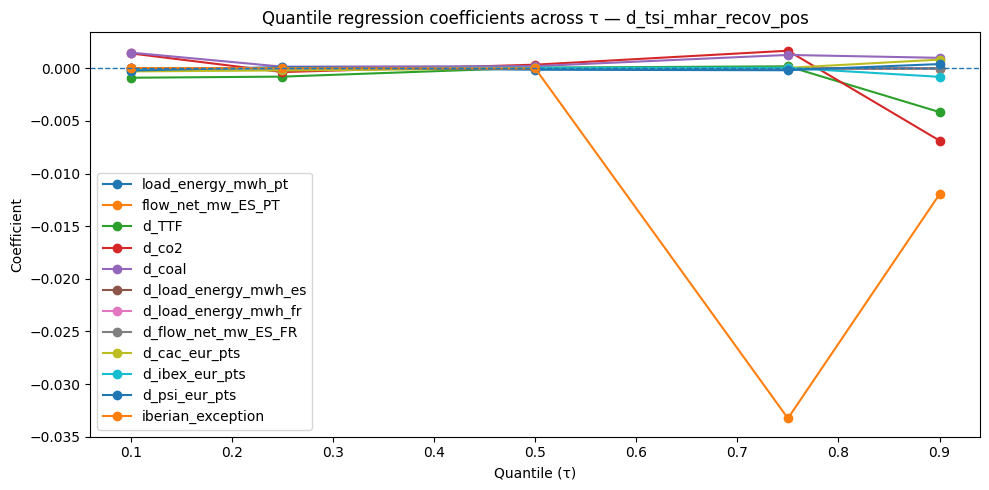

,endog,quantile,variable,coef,std_err,t,pval,ci_low,ci_high
68,d_tsi_mhar_recov_pos,0.10,d_TTF,-8.912439e-04,0.001676,-0.531755,0.595007,-0.004180,0.002397
81,d_tsi_mhar_recov_pos,0.25,d_TTF,-7.853745e-04,0.001224,-0.641758,0.521169,-0.003187,0.001616
94,d_tsi_mhar_recov_pos,0.50,d_TTF,6.722893e-05,0.000713,0.094309,0.924881,-0.001332,0.001466
107,d_tsi_mhar_recov_pos,0.75,d_TTF,1.948254e-04,0.000819,0.237888,0.812014,-0.001412,0.001802
120,d_tsi_mhar_recov_pos,0.90,d_TTF,-4.154638e-03,0.001943,-2.138532,0.032701,-0.007967,-0.000343
74,d_tsi_mhar_recov_pos,0.10,d_cac_eur_pts,-2.884221e-04,0.000177,-1.630077,0.103381,-0.000636,0.000059
87,d_tsi_mhar_recov_pos,0.25,d_cac_eur_pts,-1.973587e-04,0.000124,-1.588791,0.112405,-0.000441,0.000046
100,d_tsi_mhar_recov_pos,0.50,d_cac_eur_pts,-1.280061e-05,0.000090,-0.142795,0.886479,-0.000189,0.000163
113,d_tsi_mhar_recov_pos,0.75,d_cac_eur_pts,4.715555e-05,0.000114,0.413727,0.679158,-0.000176,0.000271
126,d_tsi_mhar_recov_pos,0.90,d_cac_eur_pts,8.329746e-04,0.000217,3.835763,0.000133,0.000407,0.001259


In [22]:
# Plot: coefficients across quantiles for ONE endog 

endog_to_plot = endog_names[1]  # change this [0, 1, 2, 3]
sub = coef_qr_df[(coef_qr_df["endog"] == endog_to_plot) & (coef_qr_df["variable"] != "const")].copy()

plt.figure(figsize=(10, 5))

for var in sub["variable"].unique():
    tmp = sub[sub["variable"] == var].sort_values("quantile")
    plt.plot(tmp["quantile"], tmp["coef"], marker="o", label=var)

plt.axhline(0, linestyle="--", linewidth=1)
plt.title(f"Quantile regression coefficients across τ — {endog_to_plot}")
plt.xlabel("Quantile (τ)")
plt.ylabel("Coefficient")
plt.legend()
plt.tight_layout()
plt.show()

display(sub.sort_values(["variable", "quantile"]).head(30))
